# Projet E-commerce Analytics

## Objectifs
Ce projet a pour objectif de concevoir et analyser une base e-commerce fictive afin d’en extraire des indicateurs clés de performance et des insights business, à l’aide de Python et SQL.

In [769]:
# Importation des librairies nécessaires
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connexion
conn = sqlite3.connect("data/ecommerce.db")

# Chargement des tables
df_customers = pd.read_sql("SELECT * FROM customers;", conn)
df_orders = pd.read_sql("SELECT * FROM orders;", conn)
df_order_items = pd.read_sql("SELECT * FROM order_items;", conn)
df_products = pd.read_sql("SELECT * FROM products;", conn)

conn.close()

In [770]:
# 1) CA total & nb de commandes
total_revenue = df_orders["total_amount"].sum()
num_orders    = df_orders["order_id"].nunique()

# 2) Panier moyen
avg_order_value = df_orders["total_amount"].mean()

# 3) Taux de réachat (clients avec ≥2 commandes)
orders_per_client = df_orders.groupby("customer_id")["order_id"].nunique()
repeat_rate = (orders_per_client.ge(2).mean() * 100)  # en %

# 4) Part du CA du meilleur pays
df_oc = df_orders.merge(df_customers, on="customer_id", how="left")
rev_by_country = df_oc.groupby("country", as_index=False)["total_amount"].sum().rename(columns={"total_amount":"revenue"})
top_country = rev_by_country.sort_values("revenue", ascending=False).iloc[0]

# 5) CA mensuel: hauts/bas
best_month = df_monthly.loc[df_monthly["revenue"].idxmax(), "order_month"]
worst_month = df_monthly.loc[df_monthly["revenue"].idxmin(), "order_month"]


print("=== KPIs flash ===")
print(f"CA total            : {total_revenue:,.2f} €")
print(f"Mois le plus fort   : {best_month}")
print(f"Mois le plus faible : {worst_month}")
print(f"Nb de commandes     : {num_orders}")
print(f"Panier moyen        : {avg_order_value:,.2f} €")
print(f"Taux de réachat     : {repeat_rate:.1f} %")
print(f"Marché principal    : {top_country['country']} (~{top_country['revenue'] / rev_by_country['revenue'].sum():.0%} du CA)")


print("\nNous allons montrer : \n • Qu'une minorité de clients génère la majorité du CA → focus fidélisation VIP")
print(" • Que la distribution des paniers est concentrée entre 50–150 € (quelques gros paniers tirent la moyenne vers le haut)")

=== KPIs flash ===
CA total            : 16,089.11 €
Mois le plus fort   : 2025-07
Mois le plus faible : 2025-09
Nb de commandes     : 120
Panier moyen        : 134.08 €
Taux de réachat     : 90.0 %
Marché principal    : UK (~42% du CA)

Nous allons montrer : 
 • Qu'une minorité de clients génère la majorité du CA → focus fidélisation VIP
 • Que la distribution des paniers est concentrée entre 50–150 € (quelques gros paniers tirent la moyenne vers le haut)


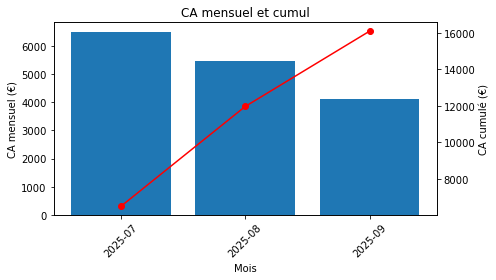

In [771]:
# Graphique CA mensuel + cumul

# 1) Recalcule proprement 
df_orders["order_date"] = pd.to_datetime(df_orders["order_date"])
df_orders["order_month"] = df_orders["order_date"].dt.to_period("M").astype(str)

df_monthly = (
    df_orders.groupby("order_month", as_index=False)["total_amount"]
             .sum()
             .rename(columns={"total_amount": "revenue"})
             .sort_values("order_month")
)
df_monthly["cumulative_revenue"] = df_monthly["revenue"].cumsum()

fig, ax1 = plt.subplots(figsize=(7,4))

ax1.bar(df_monthly["order_month"], df_monthly["revenue"])
ax1.set_xlabel("Mois")
ax1.set_ylabel("CA mensuel (€)")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_monthly["order_month"], df_monthly["cumulative_revenue"], marker="o", color="red")
ax2.set_ylabel("CA cumulé (€)")

plt.title("CA mensuel et cumul")
plt.tight_layout()
plt.show()

1.	Tendance mensuelle

	•	Juillet ≈ plus haut mois (~6 000 €) <br>
	•	Août un peu plus faible (~5 000 €) <br>
	•	Septembre encore un cran en dessous (~4 000 €) <br>
👉 Le chiffre d’affaires baisse légèrement au fil des mois <br>


2.	Cumul

	•	La courbe rouge monte régulièrement → le CA s’accumule naturellement <br>
	•	Au bout de 3 mois, environ de 15 000 € de CA total 

3.	Interprétation business

	•	“Le lancement en juillet a bien fonctionné, mais la tendance est légèrement à la baisse” <br>
	•	“Si la base s’arrêtait là, l’entreprise ferait ≈ 5 000 €/mois en moyenne” <br>
	•	“Un enjeu business serait de comprendre pourquoi septembre est plus bas (saisonnalité ? moins de clients ? moins de commandes ?)”

💡 Panier moyen global : 134.08 €

💡 Panier moyen par mois :


,order_month,avg_order_value
0,2025-07,132.741837
1,2025-08,143.813421
2,2025-09,124.843939


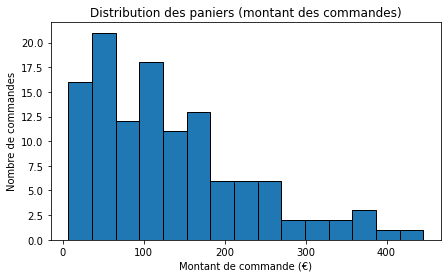

In [772]:
# Panier moyen global
print(f"💡 Panier moyen global : {avg_order_value:.2f} €")

# Panier moyen par mois
avg_by_month = (
    df_orders.groupby("order_month", as_index=False)["total_amount"]
             .mean()
             .rename(columns={"total_amount": "avg_order_value"})
)
print("\n💡 Panier moyen par mois :")
display(avg_by_month)


# Distribution des paniers
plt.figure(figsize=(7,4))
plt.hist(df_orders["total_amount"], bins=15, edgecolor="black")
plt.title("Distribution des paniers (montant des commandes)")
plt.xlabel("Montant de commande (€)")
plt.ylabel("Nombre de commandes")
plt.show()

Segment coeur : la majorité des commandes ≈ 50–150 €<br>
- Gros paniers rares : attention à ne pas se baser uniquement dessus, car ils ne représentent pas la majorité.
- Tendance mensuelle : surveiller la baisse de septembre

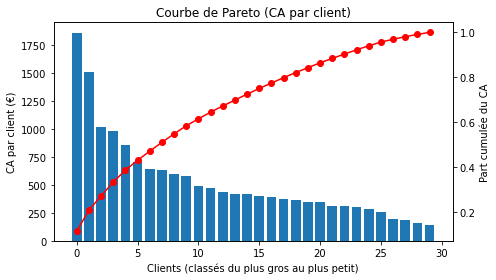

In [773]:
# CA total par client
rev_by_client = (
    df_orders.groupby("customer_id", as_index=False)["total_amount"]
             .sum()
             .rename(columns={"total_amount": "customer_revenue"})
             .sort_values("customer_revenue", ascending=False)
             .reset_index(drop=True)
)

# Ajoute une colonne "part cumulée" (% du CA global)
rev_by_client["cum_share"] = rev_by_client["customer_revenue"].cumsum() / rev_by_client["customer_revenue"].sum()

# Graph courbe de Pareto
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.bar(rev_by_client.index, rev_by_client["customer_revenue"])
ax1.set_xlabel("Clients (classés du plus gros au plus petit)")
ax1.set_ylabel("CA par client (€)")

ax2 = ax1.twinx()
ax2.plot(rev_by_client.index, rev_by_client["cum_share"], color="red", marker="o")
ax2.set_ylabel("Part cumulée du CA")

plt.title("Courbe de Pareto (CA par client)")
plt.tight_layout()
plt.show()

Environ 30 % des clients génèrent 80 % du chiffre d’affaires → concentrer les efforts de fidélisation et d’upsell sur ces clients clés

💡 Top produits :


,product_name,revenue
3,Fitness Tracker,3953.00
7,Running Shoes,3476.00
0,Bluetooth Speaker,1599.00
10,Wireless Mouse,1174.10
2,Cookbook,1134.00
11,Yoga Mat,1128.00
4,Moisturizer 50ml,982.80
6,Novel – SciFi,734.51
1,Coffee Mug,637.50
9,USB-C Cable 1m,544.50



💡 CA par catégorie :


,category,revenue
4,Sports,8557.00
2,Electronics,3317.60
1,Books,1868.51
0,Beauty,1356.60
3,Home,989.40


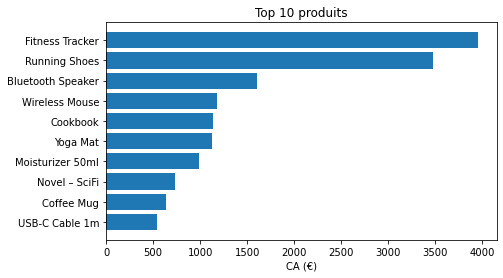

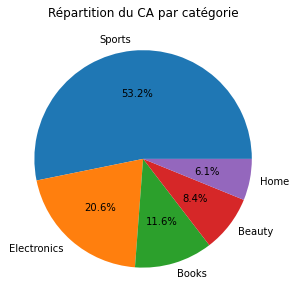

In [774]:
# Jointure commandes + items + produits
df_ip = df_items.merge(df_products, on="product_id", how="left")
df_ip = df_ip.merge(df_orders[["order_id", "order_date"]], on="order_id", how="left")

# CA par produit
rev_by_product = (
    df_ip.groupby("product_name", as_index=False)["line_amount"]
         .sum()
         .rename(columns={"line_amount": "revenue"})
         .sort_values("revenue", ascending=False)
)

# CA par catégorie
rev_by_category = (
    df_ip.groupby("category", as_index=False)["line_amount"]
         .sum()
         .rename(columns={"line_amount": "revenue"})
         .sort_values("revenue", ascending=False)
)

print("💡 Top produits :")
display(rev_by_product.head(10))

print("\n💡 CA par catégorie :")
display(rev_by_category)



# Graphs
plt.figure(figsize=(7,4))
plt.barh(rev_by_product["product_name"].head(10), rev_by_product["revenue"].head(10))
plt.xlabel("CA (€)")
plt.title("Top 10 produits")
plt.gca().invert_yaxis() # Plus grand en premier
plt.show()

plt.figure(figsize=(5,5), facecolor='white')
plt.pie(rev_by_category["revenue"], labels=rev_by_category["category"], autopct="%.1f%%")
plt.title("Répartition du CA par catégorie")
plt.show()

## Sauvegardes en local

In [775]:
# Sauvegarde des figures clés
import os

os.makedirs("reports/figures", exist_ok=True)

# 1) CA mensuel + cumul
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.bar(df_monthly["order_month"], df_monthly["revenue"])
ax1.set_xlabel("Mois"); ax1.set_ylabel("CA mensuel (€)")
ax1.tick_params(axis="x", rotation=45)
ax2 = ax1.twinx()
ax2.plot(df_monthly["order_month"], df_monthly["cumulative_revenue"], marker="o")
ax2.set_ylabel("CA cumulé (€)")
plt.title("CA mensuel et cumul")
plt.tight_layout()
fig.savefig("reports/figures/ca_mensuel_cumul.png", dpi=150, facecolor="white")
plt.close(fig)

# 2) Distribution des paniers
fig = plt.figure(figsize=(6,4))
plt.hist(df_orders["total_amount"], bins=15, edgecolor="black")
plt.title("Distribution des paniers")
plt.xlabel("Montant de commande (€)"); plt.ylabel("Nombre de commandes")
plt.tight_layout()
fig.savefig("reports/figures/distribution_paniers.png", dpi=150, facecolor="white")
plt.close(fig)

# 3) Courbe de Pareto (CA par client)
if "rev_by_client" not in globals():
    rev_by_client = (
        df_orders.groupby("customer_id", as_index=False)["total_amount"]
                 .sum()
                 .rename(columns={"total_amount": "customer_revenue"})
                 .sort_values("customer_revenue", ascending=False)
                 .reset_index(drop=True)
    )
    rev_by_client["cum_share"] = rev_by_client["customer_revenue"].cumsum() / rev_by_client["customer_revenue"].sum()

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.bar(rev_by_client.index, rev_by_client["customer_revenue"])
ax1.set_xlabel("Clients (classés)"); ax1.set_ylabel("CA par client (€)")
ax2 = ax1.twinx()
ax2.plot(rev_by_client.index, rev_by_client["cum_share"], marker="o")
ax2.set_ylabel("Part cumulée du CA")
plt.title("Pareto – CA par client")
plt.tight_layout()
fig.savefig("reports/figures/pareto_clients.png", dpi=150, facecolor="white")
plt.close(fig)

# 4) Top produits (barres horizontales)
if "rev_by_product" not in globals():
    # nécessite df_items et df_products chargés ; recharge si besoin
    if "df_items" not in globals() or "df_products" not in globals():
        import sqlite3
        conn = sqlite3.connect("data/ecommerce.db")
        df_items    = pd.read_sql("SELECT * FROM order_items;", conn)
        df_products = pd.read_sql("SELECT * FROM products;", conn)
        conn.close()
    df_ip = df_items.merge(df_products, on="product_id", how="left")
    rev_by_product = (
        df_ip.groupby("product_name", as_index=False)["line_amount"]
             .sum()
             .rename(columns={"line_amount": "revenue"})
             .sort_values("revenue", ascending=False)
    )

fig = plt.figure(figsize=(7,4))
plt.barh(rev_by_product["product_name"].head(10), rev_by_product["revenue"].head(10))
plt.xlabel("CA (€)"); plt.title("Top 10 produits")
plt.gca().invert_yaxis()
plt.tight_layout()
fig.savefig("reports/figures/top10_produits.png", dpi=150, facecolor="white")
plt.close(fig)

# 5) Répartition du CA par catégorie (camembert fond blanc)
if "rev_by_category" not in globals():
    rev_by_category = (
        df_ip.groupby("category", as_index=False)["line_amount"]
             .sum()
             .rename(columns={"line_amount": "revenue"})
             .sort_values("revenue", ascending=False)
    )

plt.figure(figsize=(5,5), facecolor="white")
plt.pie(rev_by_category["revenue"], labels=rev_by_category["category"], autopct="%.1f%%")
plt.title("Répartition du CA par catégorie")
plt.tight_layout()
plt.savefig("reports/figures/ca_par_categorie.png", dpi=150, facecolor="white")
plt.close()

In [776]:
os.makedirs("reports/data", exist_ok=True)

# 1) CA mensuel
df_monthly.to_csv("reports/data/ca_mensuel.csv", index=False)

# 2) CA par pays
df_oc = df_orders.merge(df_customers, on="customer_id", how="left")
rev_by_country = (
    df_oc.groupby("country", as_index=False)["total_amount"]
         .sum()
         .rename(columns={"total_amount": "revenue"})
         .sort_values("revenue", ascending=False)
)
rev_by_country.to_csv("reports/data/ca_par_pays.csv", index=False)

# 3) Top produits
rev_by_product.to_csv("reports/data/top_produits.csv", index=False)

# 4) Pareto clients
rev_by_client.to_csv("reports/data/pareto_clients.csv", index=False)

print("✅ Fichiers CSV enregistrés dans /reports/data :")
for f in os.listdir("reports/data"):
    print("-", f)

✅ Fichiers CSV enregistrés dans /reports/data :
- ca_par_pays.csv
- pareto_clients.csv
- top_produits.csv
- ca_mensuel.csv
